# Исправление разметки

In [1]:
import os
import sys
import glob

sys.path.insert(0, os.path.join("..", "..", ".."))

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import PIL
from PIL import Image

from well_logs import CoreBatch, CoreIndex
from well_logs.batchflow import Dataset, Pipeline, B, V, FilesIndex
from well_logs.batchflow.models.torch import ResNet18
from utils import plot_pair, make_data, get_bounds, assemble, plot_images_predictions, plot_crops_predictions, fix_annotation

Загрузим разметку для отложенной скважины

In [2]:
PATH = '/notebooks/data/processed_dataset/611'

index = FilesIndex(path=os.path.join(PATH, 'samples_dl/*.png'))

## Предобработка

In [3]:
df = pd.concat([pd.read_feather(filename) for filename in glob.glob(PATH+'/samples.feather')])
df['QC'] = 1 - df['QC']
df = df.set_index('SAMPLE')

In [4]:
index = index.create_subset(np.intersect1d(df.index.values, index.indices))
ds = Dataset(index, CoreBatch)

In [5]:
index = index.create_subset(index.indices[:10])
ds = Dataset(index, CoreBatch)

In [6]:
SHAPE = (2, 400, 150)

In [7]:
shape_ppl = (ds.p
     .load()
     .check_shapes(dst='check')
     .init_variable('quality', init_on_each_run=list)
     .update_variable('quality', B('check'), mode='e')
     .init_variable('shape1', init_on_each_run=list)
     .run(batch_size=10, n_epochs=1, shuffle=False, drop_last=False, lazy=True, bar=False)
    )

shape_ppl.run()

In [8]:
short_ppl = (ds.p
     .load()
     .find_short_cores(SHAPE[1:], dst='short')
     .init_variable('short', init_on_each_run=list)
     .update_variable('short', B('short'), mode='e')
     .run(batch_size=10, n_epochs=1, shuffle=False, drop_last=False, lazy=True, bar=False)
    )

short_ppl.run()

filtered_index = ds.index.create_subset(
    ds.indices[np.logical_not(short_ppl.get_variable('short') or shape_ppl.get_variable('quality'))]
)

In [9]:
filtered_df = Dataset(filtered_index, CoreBatch)

In [10]:
# bounds = get_bounds(PATH)

In [21]:
load_ppl = (Pipeline().load(grayscale=False, df=df).resize(size=(200, None), src='dl', dst='dl').mirror_padding((SHAPE[2], SHAPE[1])))

In [22]:
(SHAPE[2], SHAPE[1])

(150, 400)

In [23]:
ppl = load_ppl << filtered_df
b = ppl.next_batch(10)

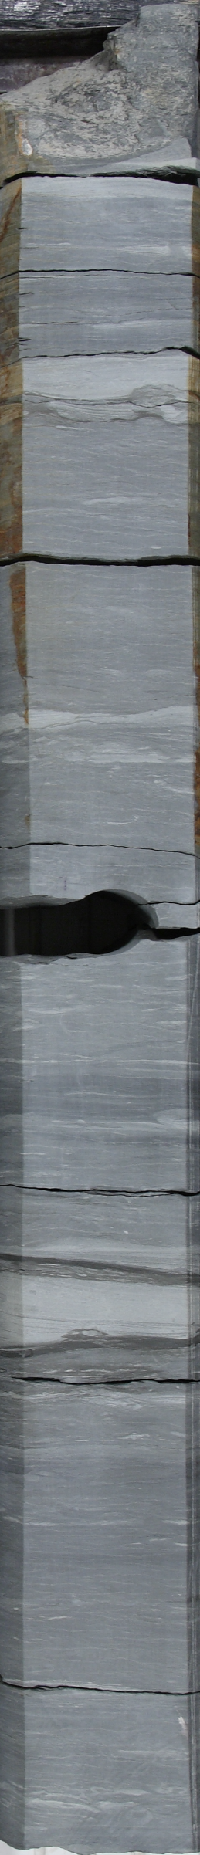

In [24]:
np.minimum

In [14]:
img = Image.open('/notebooks/data/processed_dataset/417по/samples_uv/417по_2356.58_2357.56.png').resize((80, 800))

In [15]:
def _mirror_padding(image, shape):
    new_shape = (np.array(shape) - image.size) * (np.array(shape) - image.size > 0)
    padding_shape = ((new_shape[1], new_shape[1]), (new_shape[0], new_shape[0]), (0, 0))
    return PIL.Image.fromarray(np.pad(np.array(image), padding_shape, mode='reflect'))

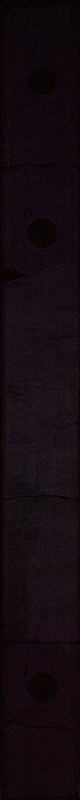

In [16]:
_mirror_padding(img, (0, 0))

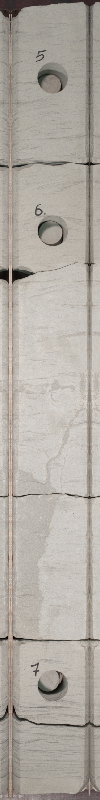

In [36]:
shape = (90, 100)
new_shape = (np.array(shape) - img.size) * (np.array(shape) - img.size > 0)
Image.fromarray(np.pad(np.array(img), ((new_shape[1], new_shape[1]), (new_shape[0], new_shape[0]), (0, 0)), mode='reflect'))

In [69]:
shape = (160, 1600)

n_mirrors = np.ceil(np.array(shape) / img.size / 2).astype('int32')
if shape[0] <= img.size[0]:
    n_mirrors[0] = 0
if shape[1] <= img.size[1]:
    n_mirrors[1] = 0

new_im = Image.new('RGB', (shape[0], img.size[1]))
mirrored_image = PIL.ImageOps.mirror(img)

x_offset = 0
images = (img, mirrored_image) if n_mirrors[0] % 2 == 0 else (mirrored_image, img)
for i in range(n_mirrors[0] * 2 + 1):
    new_im.paste(images[i % 2], (x_offset, 0))
    x_offset += img.size[0]

img = new_im

new_im = Image.new('RGB', shape)
mirrored_image = PIL.ImageOps.flip(img)

y_offset = 0
images = (img, mirrored_image) if n_mirrors[0] % 2 == 0 else (mirrored_image, img)
for i in range(n_mirrors[1] * 2 + 1):
    new_im.paste(images[i % 2], (0, y_offset))
    y_offset += img.size[1]
    
# y_offset = 0

# for i in range(2):
#     new_im.paste(img, (0, y_offset))
#     y_offset += img.size[1]
#     img = PIL.ImageOps.flip(img)

# new_im

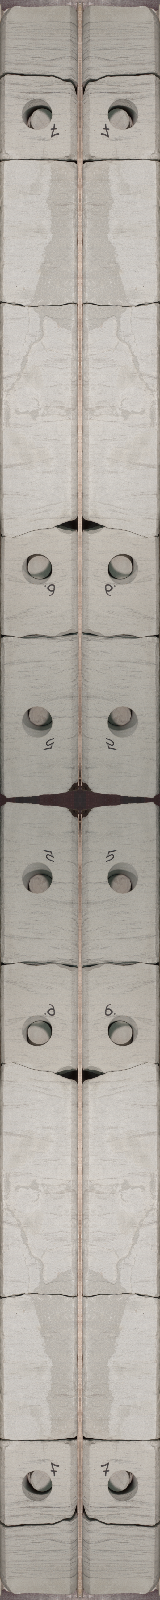

In [70]:
new_im

# Валидация

In [11]:
test_template = (Pipeline()
    .to_array(src='uv', dst='uv', channels='first')
    .to_array(src='dl', dst='dl', channels='first')
    .crop(SHAPE[1:], 200, dst=('dl_crops', 'uv_crops', 'labels_crops'))
    .init_model('dynamic', ResNet18, 'model', config={
                    'device': 'gpu:2', 'load/path': 'resnet16.torch'
                })
    .init_variable('loss', init_on_each_run=list)
    .call(make_data, save_to=(B('crops_conc'), B('labels_crops_conc')))
    .init_variable('proba', init_on_each_run=None)
    .init_variable('metrics', init_on_each_run=None)
    .predict_model('model', B('crops_conc'), targets=B('labels_crops_conc'), fetches='proba',
                 save_to=B('proba', mode='w'))
    .call(assemble, save_to=B('proba', mode='w'))
    .gather_metrics('class', targets=B('labels'), predictions=B('proba'),
                            fmt='proba', axis=-1, save_to=V('metrics', mode='u'), threshold=0.5)
    .init_variable('stat', init_on_each_run=list)
    .update_variable('stat', (B('dl'), B('uv'), B('proba'), B('labels')), mode='a')
    .run(
        batch_size=4,
        n_epochs=1,
        shuffle=False,
        drop_last=False,
        lazy=True,
        bar=True
    )
)

In [12]:
test_ppl = (load_ppl + test_template) << filtered_df

In [13]:
test_ppl.reset_iter()
test_ppl.run()

 97%|█████████▋| 30/31 [00:13<00:00,  3.61it/s]


In [14]:
metrics = test_ppl.get_variable('metrics')
print(metrics._confusion_matrix)

for m in ['specificity', 'sensitivity', 'accuracy']:
    print(m, ':', metrics.evaluate(m))

[[[109  13]
  [  0   1]]]
specificity : 1.0
sensitivity : 0.07142857142857142
accuracy : 0.8943089430894309


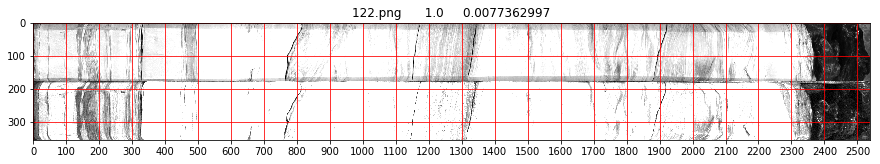

 0


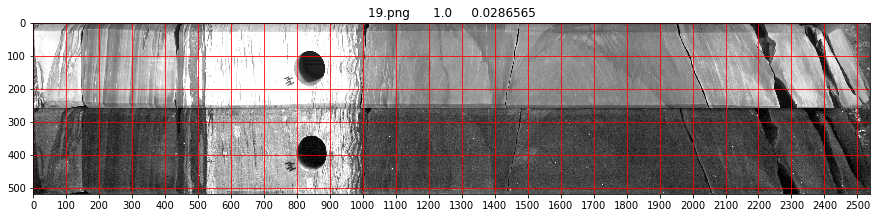

 0


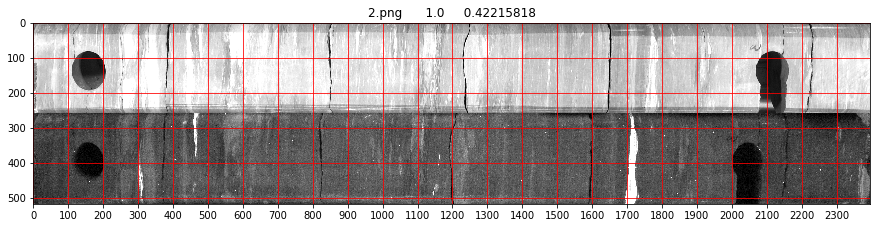

 1


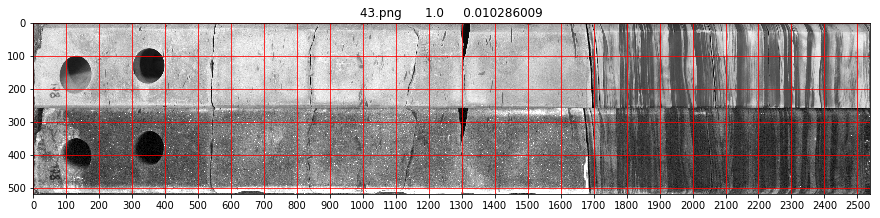

 0


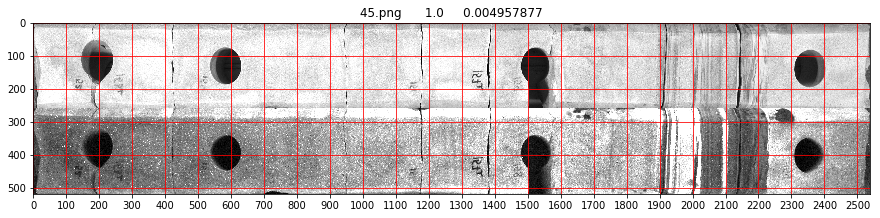

 0


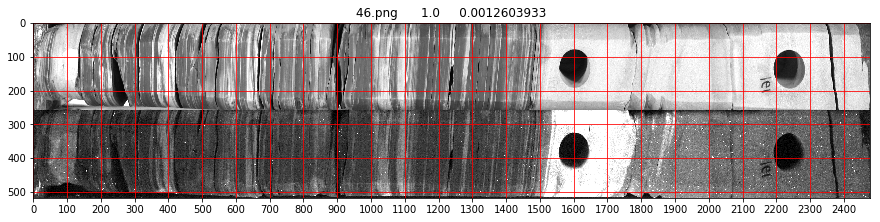

 0


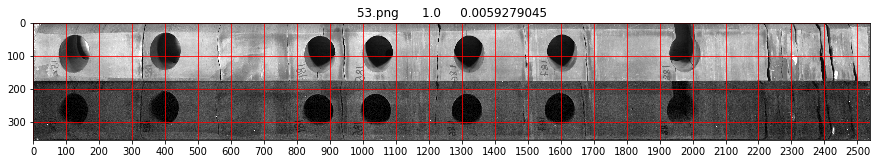

 0


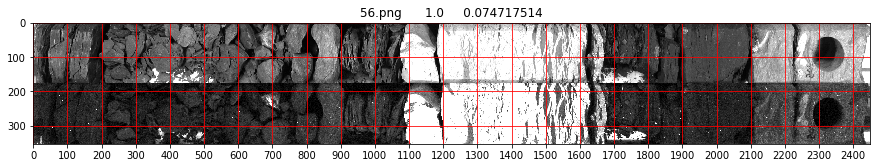

 0


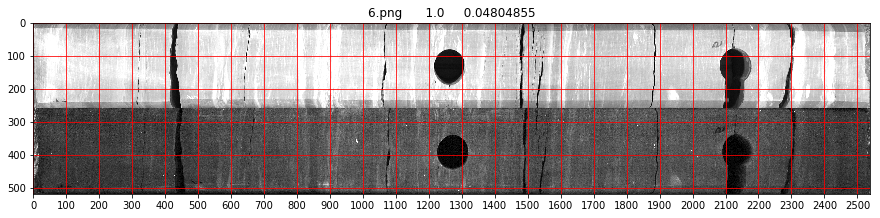

 0


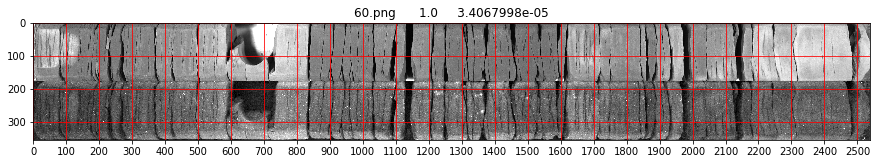

 0


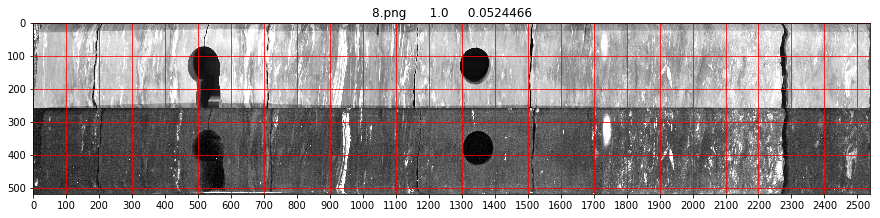

 0


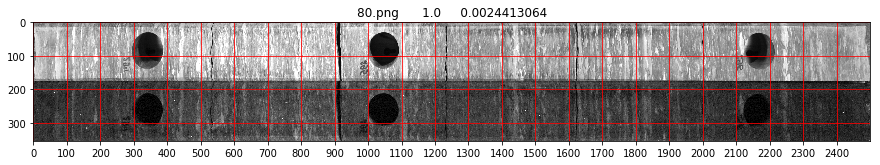

 0


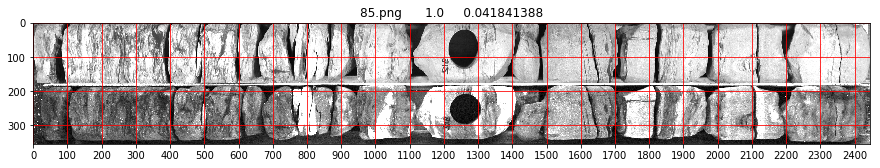

 0


In [15]:
new_df = fix_annotation(test_ppl, df)

In [16]:
new_df['QC'] = 1 - new_df['QC']
new_df.reset_index().to_feather(os.path.join(PATH, 'new_samples.feather'))